In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn import metrics
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torchsummary import summary


Text(0.5, 1.0, 'Class Imbalance')

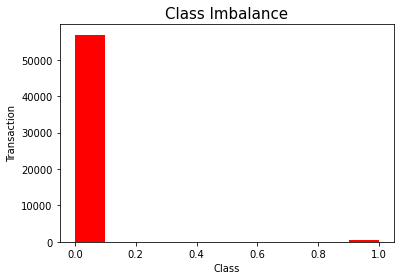

In [ ]:
data = pd.read_csv('CreditCardDataset.csv')
plt.hist(data['Class'], color='red')
plt.xlabel('Class')
plt.ylabel('Transaction')
plt.title('Class Imbalance', fontsize=15)

It can be observed that there's a hug imbalance in the data and hence the model can be biased.

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
1,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
2,7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
3,11,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,...,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,27.50,0
4,12,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,-0.436167,...,0.499625,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,15.99,0


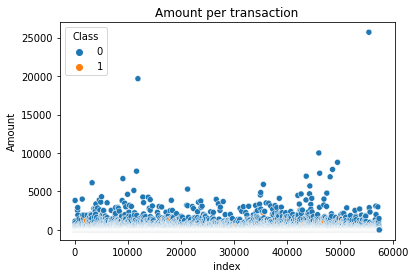

In [ ]:
#Amount per transaction
sns.scatterplot(data=data.reset_index(), x="index", y="Amount", hue="Class", cmap="YlGnBu").set(title="Amount per transaction")
plt.show()

# It is observed that fraud transactions do not tend to have a large amount of cash per transaction

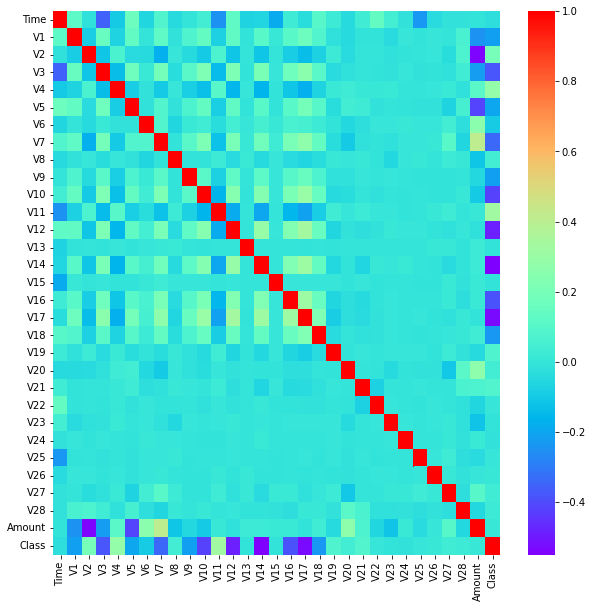

In [ ]:
#correlation matrix
%matplotlib inline
plt.figure(figsize = (10,10))
sns.heatmap(data.corr(),cmap='rainbow')
plt.show()

In [ ]:
#Some stats for positive as well as negative transactions

for i, word in zip(range(2), ["Positive", "Negative"]):
    print("{0} transactions".format(word))
    print(data[data["Class"] == i]["Amount"].describe(), "\n")

Positive transactions
count    56863.000000
mean        88.536709
std        279.670869
min          0.000000
25%          5.540000
50%         22.000000
75%         76.230000
max      25691.160000
Name: Amount, dtype: float64 

Negative transactions
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64 



In [ ]:
x = data.drop("Class", axis=1)
y = data["Class"]

In [ ]:
#scaling the values

scale = StandardScaler()
scale.fit(x)
x = scale.transform(x)

In [ ]:
# splitting data into training, testing and validation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.45, stratify=y)
pointer = int(0.55*len(x_test))
x_val, x_test, y_val, y_test = x_test[pointer:], x_test[:pointer], y_test[pointer:], y_test[:pointer]

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape

((31545, 30), (14195, 30), (31545,), (14195,), (11615, 30), (11615,))

In [ ]:
#Creating torch tensors from our dataset

x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val.values)
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_val, y_val)

In [ ]:
batch_size = 128
train_dataloaders = DataLoader(train_dataset, batch_size=batch_size)
validloader = DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=4):
        super().__init__()
        self.input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )

        self.layers = nn.ModuleList()
        for i in range(num_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.ReLU())
        
        # last layer
        self.fc = nn.Linear(hidden_dim, 2)
        
    def forward(self, x):
        pred = self.input(x)
        for layer in self.layers:
            pred = layer(pred)
        return self.fc(pred)

In [ ]:
def train(model, epochs, loss_function, optimizer):
    training_loss = []
    validation_loss = []
    training_accuracy = []
    validation_accuracy = []
    running_train_loss = 0.0 
    running_train_accuracy = 0.0 
    running_val_loss = 0.0
    running_val_accuracy = 0.0
    model.train()   
    for epoch in range(epochs):
        with tqdm(train_dataloaders, unit="batch") as tepoch:
            for data, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                optimizer.zero_grad()
                preds = model(data)
                train_loss = loss_function(preds, target.long())
                train_loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=train_loss.item())
                running_train_loss +=train_loss.item()
                training_loss.append(running_train_loss/len(train_dataloaders))
                _, predicted = torch.max(preds, 1)
                running_train_accuracy += (predicted == target.long()).sum().item()
                training_accuracy.append(running_train_accuracy/len(train_dataloaders))
                
        with tqdm(validloader, unit="batch") as tepoch:
            for data, target in tepoch:    
                tepoch.set_description(f"Epoch {epoch}")
                optimizer.zero_grad()
                preds = model(data)
                valid_loss = loss_function(preds, target.long())
                valid_loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=valid_loss.item())
                running_val_loss += valid_loss.item()
                validation_loss.append(running_val_loss/len(validloader))
                _, predicted = torch.max(preds, 1)
                running_val_accuracy += (predicted == target.long()).sum().item()
                validation_accuracy.append(running_val_accuracy/len(validloader))
    return(training_loss,validation_loss,training_accuracy,validation_accuracy )

In [ ]:
input_size = x_train.shape[1]
model = NeuralNet(input_size, input_size)
loss = nn.CrossEntropyLoss()
model_optimizer = torch.optim.Adam(model.parameters(),  lr = 1e-4)
epochs = 10

In [ ]:
#Model Summary
summary(model, (input_size, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 30, 30]             930
              ReLU-2               [-1, 30, 30]               0
            Linear-3               [-1, 30, 30]             930
              ReLU-4               [-1, 30, 30]               0
            Linear-5               [-1, 30, 30]             930
              ReLU-6               [-1, 30, 30]               0
            Linear-7               [-1, 30, 30]             930
              ReLU-8               [-1, 30, 30]               0
            Linear-9               [-1, 30, 30]             930
             ReLU-10               [-1, 30, 30]               0
           Linear-11                [-1, 30, 2]              62
Total params: 4,712
Trainable params: 4,712
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

In [ ]:
training_loss,validation_loss,training_accuracy,validation_accuracy = train(model, epochs, loss, model_optimizer)

Epoch 9: 100%|██████████| 91/91 [00:01<00:00, 82.45batch/s, loss=0.00171]


In [ ]:
model.eval()


NeuralNet(
  (input): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ReLU()
  )
  (layers): ModuleList(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=30, out_features=2, bias=True)
)

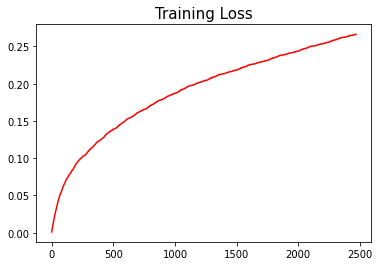

In [ ]:
plt.title('Training Loss', fontsize=15)
plt.plot(np.array(training_loss), 'r')


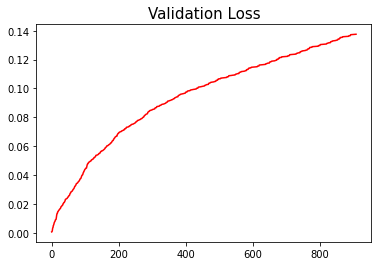

In [ ]:
plt.title('Validation Loss', fontsize=15)
plt.plot(np.array(validation_loss), 'r')


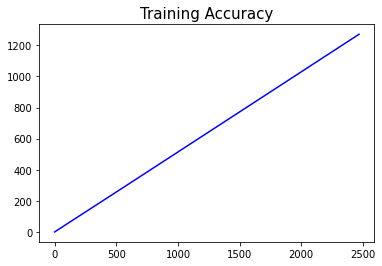

In [ ]:
plt.title('Training Accuracy', fontsize=15)
plt.plot(np.array(training_accuracy), 'b')


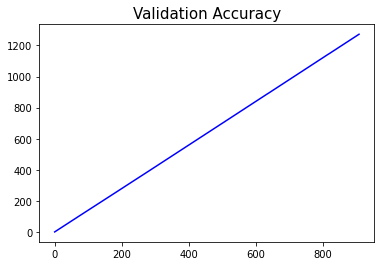

In [ ]:
plt.title('Validation Accuracy', fontsize=15)
plt.plot(np.array(validation_accuracy), 'b')


In [ ]:
preds = model(x_test).argmax(dim=1)
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14067
         1.0       0.98      0.76      0.85       128

    accuracy                           1.00     14195
   macro avg       0.99      0.88      0.93     14195
weighted avg       1.00      1.00      1.00     14195



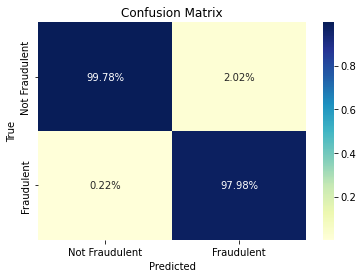

In [ ]:
class_dict = {0 : "Not Fraudulent", 1 : "Fraudulent"}
cm_df = pd.DataFrame(metrics.confusion_matrix(y_test, preds)).rename(columns=class_dict, index=class_dict)
cm_df = cm_df / np.sum(cm_df)
sns.heatmap(cm_df, annot=True, fmt='0.2%', cmap="YlGnBu").set(title="Confusion Matrix", xlabel="Predicted", ylabel="True")
plt.show()